In [49]:
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm





## ex 1 - loading the dataset (it's only 1 column)

In [26]:
#ex 1 - loading the dataset (it's only 1 column)

df = pd.read_csv('bandwidth.csv')


#the bandwidth usage started on the 1st of january of 2019
# namdwidth is measured in Mbps (megabits per second) which equals 106 bps

start_date = '2019-1-1'
end_date = pd.to_datetime(start_date) + pd.DateOffset(hours=len(df) - 1)
df['time'] = pd.date_range(start=start_date, end=end_date, freq='H')


# Set 'time' as the index
df.set_index('time', inplace=True)
print(df)


df_train = df['hourly_bandwidth'].iloc[:-7*24]
df_test = df['hourly_bandwidth'].iloc[-(7*24):]

                     hourly_bandwidth
time                                 
2019-01-01 00:00:00       1000.496714
2019-01-01 01:00:00       1000.969408
2019-01-01 02:00:00       1002.046019
2019-01-01 03:00:00       1004.702118
2019-01-01 04:00:00       1007.447816
...                               ...
2020-02-21 11:00:00        740.546059
2020-02-21 12:00:00        738.906228
2020-02-21 13:00:00        736.057995
2020-02-21 14:00:00        733.559640
2020-02-21 15:00:00        732.190049

[10000 rows x 1 columns]


## ex2 - Visualize the time series.

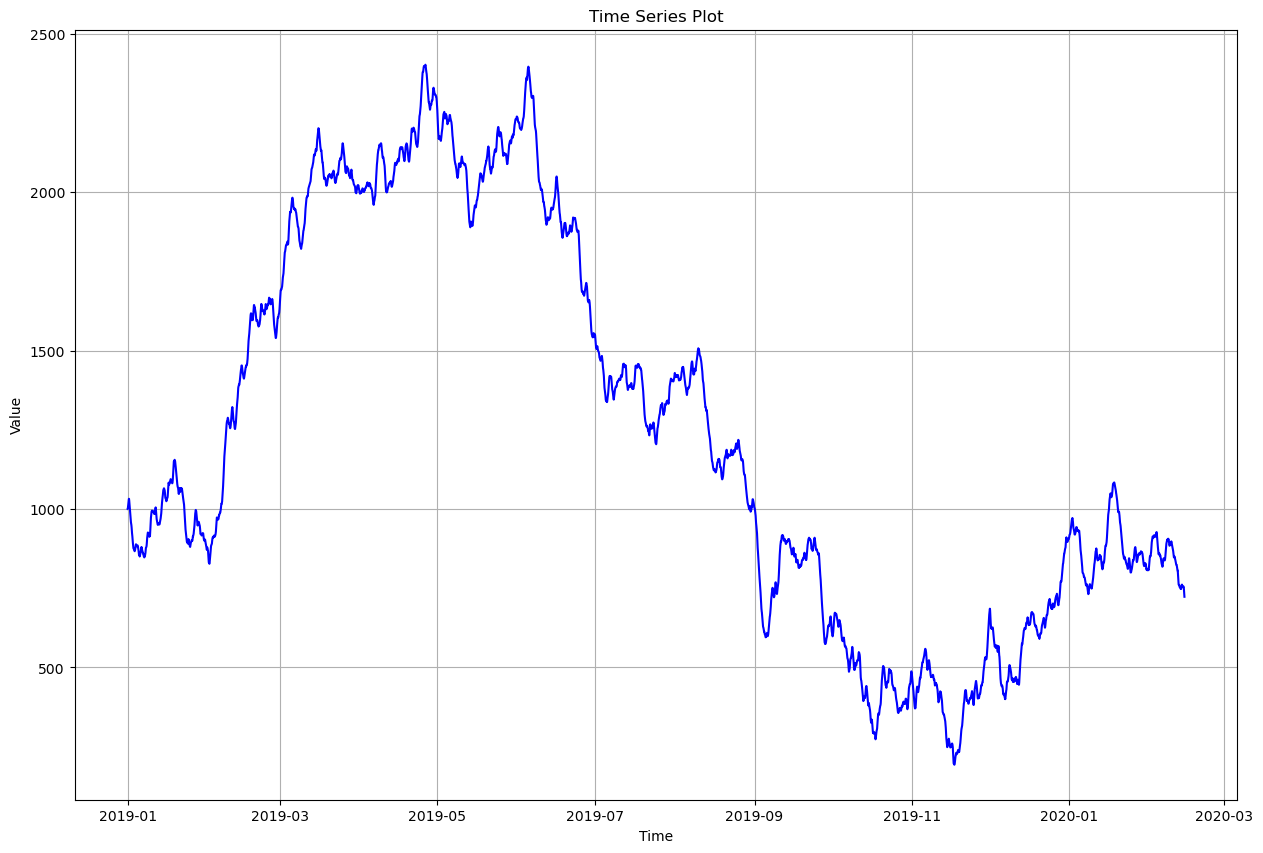

In [27]:
#ex2 - Visualize the time series.
#better to plot this time series

plt.figure(figsize=(15, 10))
plt.plot( df_train, linestyle='-', color='b')
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## ex 3 - Verify if the time series is stationary.

In [24]:
#ex3
# let's use the acrf to verify wether the time series is stationary

ADF_result = adfuller(df_train)

print(f"ADF Statistic: {round(ADF_result[0], 3)}")
print(f"p-value: {round(ADF_result[1], 3)}")

if round(ADF_result[1], 3) < 0.05:
    print('Time Series is Stationary!')
else:
    print('Time Series is not Stationary!')


ADF Statistic: -0.822
p-value: 0.813
Time Series is not Stationary!


## ex4 - Based on your exploration, determine the most suitable model with the usual steps:

                     hourly_bandwidth
time                                 
2019-01-01 01:00:00          0.472694
2019-01-01 02:00:00          1.076611
2019-01-01 03:00:00          2.656099
2019-01-01 04:00:00          2.745698
2019-01-01 05:00:00          2.246164
...                               ...
2020-02-21 11:00:00         -0.387182
2020-02-21 12:00:00         -1.639832
2020-02-21 13:00:00         -2.848232
2020-02-21 14:00:00         -2.498356
2020-02-21 15:00:00         -1.369591

[9999 rows x 1 columns]
ADF Statistic: -20.695
p-value: 0.0
Time Series is Stationary!


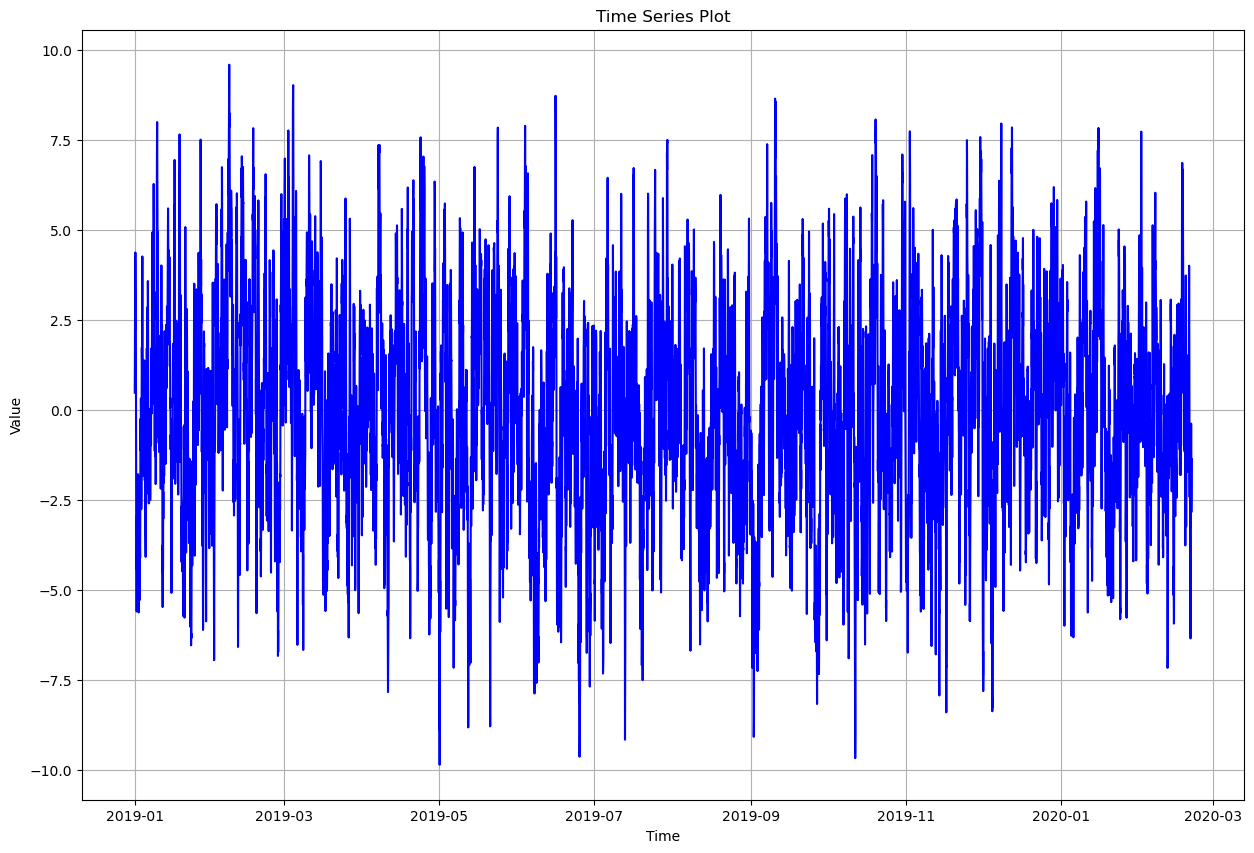

In [29]:
# a. Apply the transformations to make the time series stationary

#let's apply differencing



df_train_diff = pd.DataFrame({
    # 'time': df['time'].iloc[1:],  # Exclude the first row of time
    'hourly_bandwidth': df['hourly_bandwidth'].diff().iloc[1:]
})
df_train_diff.dropna(inplace=True)

print(df_train_diff)

ADF_result = adfuller(df_train_diff['hourly_bandwidth'])

print(f"ADF Statistic: {round(ADF_result[0], 3)}")
print(f"p-value: {round(ADF_result[1], 3)}")

if round(ADF_result[1], 3) < 0.05:
    print('Time Series is Stationary!')
else:
    print('Time Series is not Stationary!')


plt.figure(figsize=(15, 10))
plt.plot( df_train_diff['hourly_bandwidth'], linestyle='-', color='b')
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()




<Figure size 1200x400 with 0 Axes>

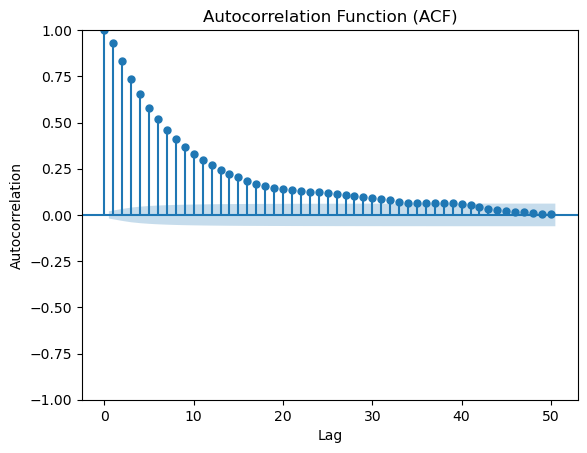

<Figure size 1200x400 with 0 Axes>

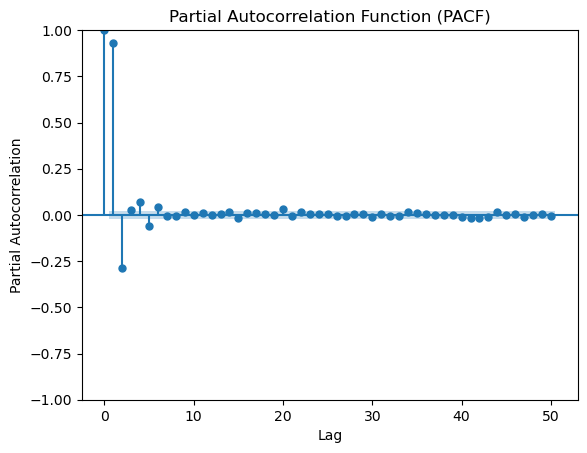

In [30]:
# b. Determine the adequate model to predict the series by plotting the autocorrelation and partial


# Plot ACF
plt.figure(figsize=(12, 4))
plot_acf(df_train_diff['hourly_bandwidth'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 4))
plot_pacf(df_train_diff['hourly_bandwidth'], lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


### Answer: the adequate model is ARMA(p, q)

In [31]:
# autocorrelation functions
# c. Find the optimal (p , q) parameters.

def generate_order_list(x, y):
    # Generate all combinations of p and q within the specified range
    orders = list(itertools.product(range(x, y+1), repeat=2))

    # Filter out combinations where p and q are not distinct (optional)
    orders = [order for order in orders if order[0] != order[1]]

    return orders




def optimize_ARMA(data, order_list) -> pd.DataFrame:
    # print(data)
    results = []
    for order in order_list:
        try:
            model = SARIMAX(data, order=(order[0], 0, order[1]), simple_differencing=False)

        except:
            continue

        aic = model.fit(disp=False).aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


# print(optimize_ARMA(df_diff['hourly_bandwidth'], generate_order_list(1, 5)))



best_aic = optimize_ARMA(df_train_diff['hourly_bandwidth'], generate_order_list(1, 5))

print(best_aic)

/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

     (p,q)           AIC
0   (3, 2)  28451.239020
1   (2, 3)  28451.415534
2   (1, 5)  28452.019940
3   (4, 2)  28452.797770
4   (2, 4)  28453.233812
5   (5, 2)  28453.287846
6   (4, 3)  28453.413771
7   (5, 3)  28454.072570
8   (1, 4)  28454.142962
9   (2, 5)  28454.279537
10  (4, 5)  28454.385342
11  (3, 4)  28455.374598
12  (3, 5)  28455.666369
13  (5, 4)  28456.621550
14  (5, 1)  28458.903053
15  (1, 3)  28462.681589
16  (4, 1)  28463.453262
17  (1, 2)  28511.683945
18  (3, 1)  28534.528098
19  (2, 1)  28559.689002


In [36]:
# d. Fit the ARMA(p,q) model with the optimal parameters on the training set

p, q = best_aic['(p,q)'].iloc[0]


# Fit ARMA(p,q) model
model = sm.tsa.ARIMA(df_train, order=(p, 0, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       hourly_bandwidth   No. Observations:                 9832
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -13997.899
Date:                Wed, 29 Nov 2023   AIC                          28009.799
Time:                        20:22:09   BIC                          28060.153
Sample:                    01-01-2019   HQIC                         28026.858
                         - 02-14-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1241.0726    546.155      2.272      0.023     170.628    2311.517
ar.L1          1.3488      0.052     26.158      0.000       1.248       1.450
ar.L2          0.1254      0.099      1.270      0.2

<Figure size 1200x400 with 0 Axes>

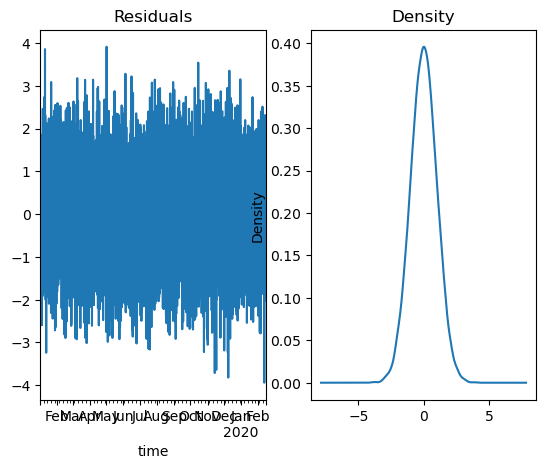

<Figure size 1200x400 with 0 Axes>

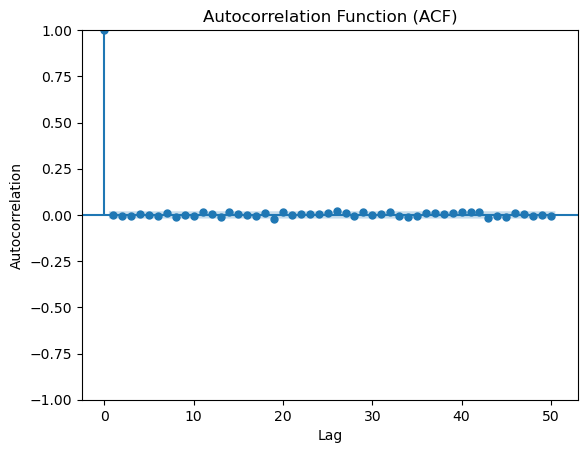

<Figure size 1200x400 with 0 Axes>

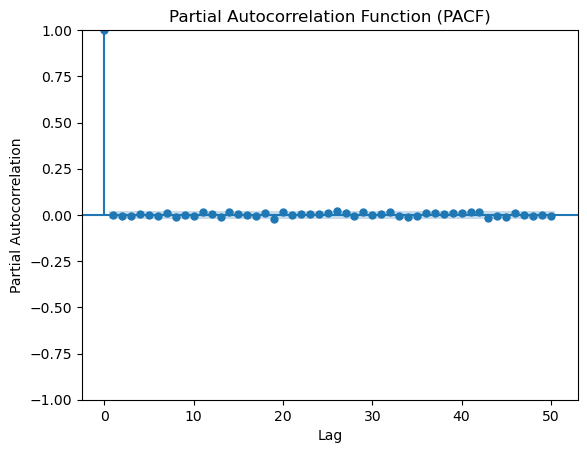

In [41]:
# e. Perform the residual analysis to validate if the model can be used to forecast.
residuals = model_fit.resid[1:]

residuals_test = acorr_ljungbox(residuals, np.arange(1, 11, 1))

residuals_test['lb_pvalue'].describe()


plt.figure(figsize=(12, 4))
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(title="Density", kind='kde', ax=ax[1])
plt.show


# Plot ACF
plt.figure(figsize=(12, 4))
plot_acf(residuals, lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 4))
plot_pacf(residuals, lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()



<Axes: xlabel='time'>

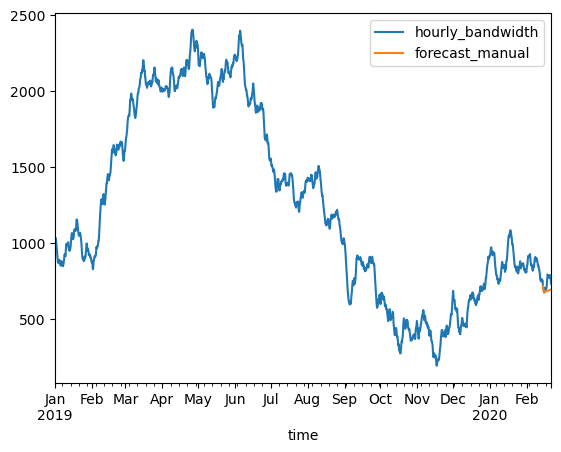

In [42]:
#ex5 - Predict a full week of the bandwidth usage using the last week of points as test set.


# df_except_last7days = df['hourly_bandwidth'].iloc[:-7*24]
# df_last7days = df['hourly_bandwidth'].iloc[-(7*24):]
#print(df_last7days)

forecast_test = model_fit.forecast(len(df_test))

df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)
df.plot()



In [57]:
#ex6

#Assuming df_test is the test set and df has 'forecast_manual' column from ARMA predictions



mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f"mae: {mae}")
print(f"mape: {mape}")
print(f"rmse: {rmse}")

# Calculate mean and last known value for baseline
mean_baseline = df_train.mean()
last_known_value_baseline = df_train.iloc[-1]

# Make predictions for the test set using baseline models
mean_method_predictions = np.full(len(df_test), mean_baseline)
last_known_value_predictions = np.full(len(df_test), last_known_value_baseline)


# Evaluate ARMA model
mae_arma = mean_absolute_error(df_test, forecast_test)
mae_mean = mean_absolute_error(df_test, mean_method_predictions)
mae_last_known_value = mean_absolute_error(df_test, last_known_value_predictions)

mse_arma = mean_squared_error(df_test, forecast_test)
mse_mean = mean_squared_error(df_test, mean_method_predictions)
mse_last_known_value = mean_squared_error(df_test, last_known_value_predictions)

# Print or use the predictions as needed
# print(mean_method_predictions)
# print(last_known_value_predictions)

# Print evaluation metrics
print(f'MAE - ARMA: {mae_arma}, Mean Method: {mae_mean}, Last Known Value: {mae_last_known_value}')
print(f'MSE - ARMA: {mse_arma}, Mean Method: {mse_mean}, Last Known Value: {mse_last_known_value}')


mae: 52.46643615111262
mape: 0.06847384090319468
rmse: 64.599468692536
MAE - ARMA: 52.46643615111262, Mean Method: 502.27358246156535, Last Known Value: 38.732467012377995
MSE - ARMA: 4173.09135535794, Mean Method: 253895.5725558025, Last Known Value: 1862.6246081808938


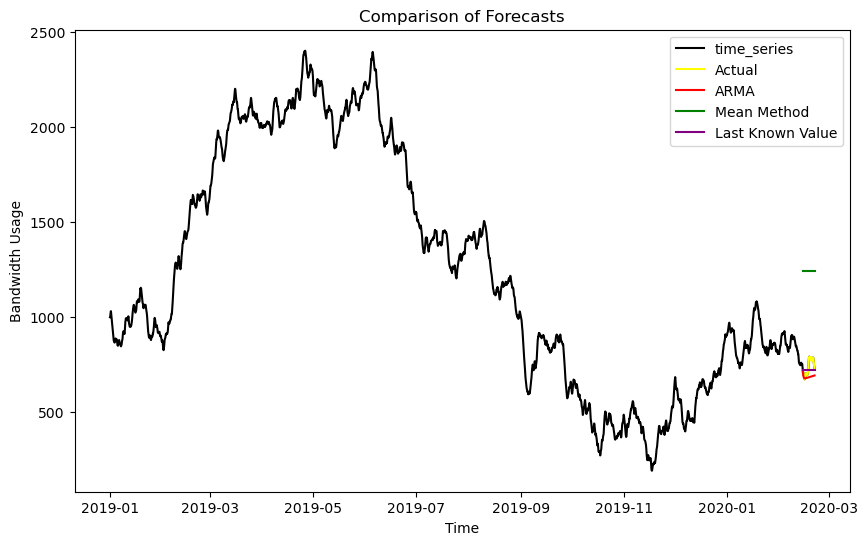

In [72]:

#ex7 - Visualize all the forecasts in a single graph.
#plt.plot(df['hourly_bandwidth'], label='time_series', color='black')


# # Visualize predictions
# plt.figure(figsize=(10, 6))




# # Plot actual values
# plt.plot(df_test, label='Test', color='blue')

# # Plot ARMA predictions
# plt.plot(forecast_test, label='ARMA', color='red')

# # Plot mean method predictions
# # plt.plot(mean_method_predictions, label='Mean Method', color='green')

# # Plot last known value method predictions
# # plt.plot(last_known_value_predictions, label='Last Known Value', color='purple')

# # Customize the plot
# plt.xlabel('Time')
# plt.ylabel('Bandwidth Usage')
# plt.title('Comparison of Forecasts')
# plt.legend()
# plt.show()


# print(len(mean_method_predictions))

# Visualize predictions
plt.figure(figsize=(10, 6))


#
plt.plot(df['hourly_bandwidth'], label='time_series', color='black')


# Plot actual values
plt.plot(df_test.index, df_test, label='Actual', color='blue')

# Plot ARMA predictions
plt.plot(df_test.index, forecast_test, label='ARMA', color='red')

# Plot mean method predictions (related to the last 7 days)
plt.plot(df_test.index, mean_method_predictions, label='Mean Method', color='green')

# Plot last known value method predictions (related to the last 7 days)
plt.plot(df_test.index, last_known_value_predictions, label='Last Known Value', color='purple')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Bandwidth Usage')
plt.title('Comparison of Forecasts')
plt.legend()
plt.show()